In [1]:
# arrays
import numpy as np
from matplotlib import pyplot as plt
import itertools

from astropy.table import Table

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from scipy.stats import randint, uniform

# sklearn 
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 

tab = Table.read('3dhst_master.phot.v4.1.csv', format='ascii').to_pandas()
target = 'z_spec'  

## Preprocessing

In [2]:
# -------------------------
# 0) Basic quality cuts BEFORE feature engineering
# -------------------------
must_have = {'use_phot', 'z_spec'}
if must_have.issubset(tab.columns):
    mask = (tab['use_phot'] == 1) & (tab[target] > 0)
    if 'lmass' in tab.columns:
        mask &= (tab['lmass'] > 9)
    tab = tab[mask].copy()

In [3]:
# -------------------------
# 1) Clean error columns
# -------------------------
errors = [c for c in tab.columns if (c.startswith('e_') and c.endswith('W')) or c.startswith('eaper_')]
for e in errors:
    tab.loc[(~np.isfinite(tab[e])) | (tab[e] <= 0) | (tab[e] < -90), e] = np.nan


In [4]:
# -------------------------
# 2) Transfer all fluxes to AB magnitudes (zeropoint = 25)
# -------------------------
bands = ['F606W', 'F814W', 'F140W', 'F160W', 'F125W']
for b in bands:
    fcol = f'f_{b}'
    if fcol in tab.columns:
        tab.loc[(~np.isfinite(tab[fcol])) | (tab[fcol] <= 0), fcol] = np.nan
        tab[f'mag_{b}'] = 25.0 - 2.5 * np.log10(np.clip(tab[fcol].to_numpy(), 1e-6, np.inf))


In [5]:
# -------------------------
# 3) Add color features: ALL pairwise colors (no duplicates)
# -------------------------
mag_cols = [f'mag_{b}' for b in bands if f'mag_{b}' in tab.columns]
for a, b in itertools.combinations(mag_cols, 2):
    band_a = a.replace('mag_', '')
    band_b = b.replace('mag_', '')
    tab[f'color_{band_a}_{band_b}'] = tab[a] - tab[b]

In [6]:
# -------------------------
# 4) Add axis ratio b/a (simple morphology)
# -------------------------
if {'a_image', 'b_image'}.issubset(tab.columns):
    tab['axis_ratio'] = tab['b_image'] / (tab['a_image'] + 1e-6)

In [7]:
# -------------------------
# 5) Assemble feature list 
# -------------------------
feature_cols = []
# magnitudes
for b in bands:
    c = f'mag_{b}'
    if c in tab.columns:
        feature_cols.append(c)
# all pairwise colors
for a, b in itertools.combinations([bb for bb in bands if f'mag_{bb}' in tab.columns], 2):
    c = f'color_{a}_{b}'
    if c in tab.columns:
        feature_cols.append(c)
# axis ratio (optional)
if 'axis_ratio' in tab.columns:
    feature_cols.append('axis_ratio')
# other scalar features (only add if present)
for extra in ['flux_radius', 'fwhm_image', 'kron_radius', 'tot_cor']:
    if extra in tab.columns:
        feature_cols.append(extra)

In [8]:
# -------------------------
# 5b) Add S/N features per band (if both flux & error exist)
# -------------------------
for b in bands:
    f = f"f_{b}"
    e = f"e_{b}"
    if f in tab.columns and e in tab.columns:
        sn = f"snr_{b}"
        tab[sn] = np.where((tab[e] > 0) & np.isfinite(tab[e]), tab[f]/tab[e], np.nan)
        if sn not in feature_cols:
            feature_cols.append(sn)

In [9]:
#tab = tab.dropna(subset=feature_cols + [target])

In [10]:
X = tab[feature_cols]   # DataFrame (keep names for ColumnTransformer)
y = tab[target].values
indices = np.arange(len(y))

n_bins = 10  # reduce if you get "least populated class has only 1 member"
quantiles = np.quantile(y, np.linspace(0, 1, n_bins + 1))
quantiles = np.unique(quantiles)
if len(quantiles) < 3:
    quantiles = np.quantile(y, np.linspace(0, 1, 6))  # 5 bins
y_bins_all = np.digitize(y, quantiles[1:-1], right=True)

# 6.1 Train vs temp (val+test)
X_train, X_temp, y_train, y_temp, indices_train, indices_temp, bins_train, bins_temp = train_test_split(
    X, y, indices, y_bins_all,
    test_size=0.30, random_state=42, stratify=y_bins_all
)

# 6.2 Temp → validation & test (50/50), stratified within temp
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(
    X_temp, y_temp, indices_temp,
    test_size=0.50, random_state=42, stratify=bins_temp
)

In [11]:
pre = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median", add_indicator=True), feature_cols)
    ],
    remainder="drop",
)
# NaN -> median

---

## Models

### Random Forest

In [12]:
rf_best = RandomForestRegressor(
    n_estimators=527,
    max_depth=17,
    max_features=0.7578185914055438,
    max_samples=0.9040601897822085,
    min_samples_leaf=1,
    min_samples_split=7,
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

rf = Pipeline([
    ("pre", pre),
    ("reg", TransformedTargetRegressor(
        regressor=rf_best, func=np.log1p, inverse_func=np.expm1
    )),
])

rf.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'),
                                                  ['mag_F606W', 'mag_F814W',
                                                   'mag_F140W', 'mag_F160W',
                                                   'mag_F125W',
                                                   'color_F606W_F814W',
                                                   'color_F606W_F140W',
                                                   'color_F606W_F160W',
                                                   'color_F606W_F125W',
                                                   'color_F814W_F140W',
                                                   'color_F814W_F160W',
                                                   'color_F814W_F125W',
                                                   'color_F140W_F160W',
                                                   'color_F140W_F1...
                                                   'fwhm_image', 'kron_radius',
                                                   'tot_cor', 'snr_F606W',
                                                   'snr_F814W', 'snr_F140W',
                                                   'snr_F160W',
                                                   'snr_F125W'])])),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(max_depth=17,
                                                                            max_features=0.7578185914055438,
                                                                            max_samples=0.9040601897822085,
                                                                            min_samples_split=7,
                                                                            n_estimators=527,
                                                                            n_jobs=-1,
                                                                            oob_score=True,
                                                                            random_state=42)))])

### Gradient Boosting

In [13]:
gbr_best = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    random_state=42
)

gbr = Pipeline([
    ("pre", pre),
    ("reg", TransformedTargetRegressor(
        regressor=gbr_best, func=np.log1p, inverse_func=np.expm1
    )),
])

gbr.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'),
                                                  ['mag_F606W', 'mag_F814W',
                                                   'mag_F140W', 'mag_F160W',
                                                   'mag_F125W',
                                                   'color_F606W_F814W',
                                                   'color_F606W_F140W',
                                                   'color_F606W_F160W',
                                                   'color_F606W_F125W',
                                                   'color_F814W_F140W',
                                                   'color_F814W_F160W',
                                                   'color_F814W_F125W',
                                                   'color_F140W_F160W',
                                                   'color_F140W_F125W',
                                                   'color_F160W_F125W',
                                                   'axis_ratio', 'flux_radius',
                                                   'fwhm_image', 'kron_radius',
                                                   'tot_cor', 'snr_F606W',
                                                   'snr_F814W', 'snr_F140W',
                                                   'snr_F160W',
                                                   'snr_F125W'])])),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=GradientBoostingRegressor(learning_rate=0.01,
                                                                                max_depth=5,
                                                                                n_estimators=1000,
                                                                                random_state=42)))])

### XGBoost

In [14]:
xgb_best = XGBRegressor(
    n_estimators=2500,
    learning_rate=0.005,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

xgb = Pipeline([
    ("pre", pre),
    ("reg", TransformedTargetRegressor(
        regressor=xgb_best, func=np.log1p, inverse_func=np.expm1
    )),
])

xgb.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'),
                                                  ['mag_F606W', 'mag_F814W',
                                                   'mag_F140W', 'mag_F160W',
                                                   'mag_F125W',
                                                   'color_F606W_F814W',
                                                   'color_F606W_F140W',
                                                   'color_F606W_F160W',
                                                   'color_F606W_F125W',
                                                   'color_F814W_F140W',
                                                   'color_F814W_F160W',
                                                   'color_F814W_F125W',
                                                   'color_F140W_F160W',
                                                   'color_F140W_F1...
                                                                   feature_weights=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.005,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=5,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=2500,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...)))])

### Light GBM

In [15]:
lgbm_best = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=8,
    min_child_samples=5,
    random_state=42,
    n_jobs=-1
)

lgbm = Pipeline([
    ("pre", pre),
    ("reg", TransformedTargetRegressor(
        regressor=lgbm_best, func=np.log1p, inverse_func=np.expm1
    )),
])

lgbm.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6240
[LightGBM] [Info] Number of data points in the train set: 2779, number of used features: 40
[LightGBM] [Info] Start training from score 0.646776


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'),
                                                  ['mag_F606W', 'mag_F814W',
                                                   'mag_F140W', 'mag_F160W',
                                                   'mag_F125W',
                                                   'color_F606W_F814W',
                                                   'color_F606W_F140W',
                                                   'color_F606W_F160W',
                                                   'color_F606W_F125W',
                                                   'color_F814W_F140W',
                                                   'color_F814W_F160W',
                                                   'color_F814W_F125W',
                                                   'color_F140W_F160W',
                                                   'color_F140W_F1...
                                                   'color_F160W_F125W',
                                                   'axis_ratio', 'flux_radius',
                                                   'fwhm_image', 'kron_radius',
                                                   'tot_cor', 'snr_F606W',
                                                   'snr_F814W', 'snr_F140W',
                                                   'snr_F160W',
                                                   'snr_F125W'])])),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LGBMRegressor(learning_rate=0.05,
                                                                    max_depth=7,
                                                                    min_child_samples=5,
                                                                    n_estimators=300,
                                                                    n_jobs=-1,
                                                                    num_leaves=8,
                                                                    random_state=42)))])

In [16]:
# Random Forest
y_predict_validate_rf = rf.predict(X_validate)
mse_rf = mean_squared_error(y_validate, y_predict_validate_rf)
r2_rf = r2_score(y_validate, y_predict_validate_rf)

# Gradinet Boosting
y_predict_validate_gbr = gbr.predict(X_validate)
mse_gbr = mean_squared_error(y_validate, y_predict_validate_gbr)
r2_gbr = r2_score(y_validate, y_predict_validate_gbr)

# XGBoost
y_predict_validate_xgb = xgb.predict(X_validate)
mse_xgb = mean_squared_error(y_validate, y_predict_validate_xgb)
r2_xgb = r2_score(y_validate, y_predict_validate_xgb)

# Light GBM
y_predict_validate_lgbm = lgbm.predict(X_validate)
mse_lgbm = mean_squared_error(y_validate, y_predict_validate_lgbm)
r2_lgbm = r2_score(y_validate, y_predict_validate_lgbm)

# Skelton et al. 2014
y_skelton2014 = tab['z_peak'].values[indices_validate]
mse_skelton = mean_squared_error(y_validate, y_skelton2014)
r2_skelton = r2_score(y_validate, y_skelton2014)

c:\Users\user\anaconda3\envs\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### MLP

In [17]:
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
            ("scaler", StandardScaler())
        ]), feature_cols)
    ],
    remainder="drop",
)

X_train_scaled = pre.fit_transform(X_train)
X_validate_scaled = pre.transform(X_validate)
X_test_scaled = pre.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_validate_tensor = torch.tensor(X_validate_scaled, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(TensorDataset(X_validate_tensor, y_validate_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32)
            if x_tensor.ndim == 1:
                x_tensor = x_tensor.unsqueeze(0)
            outputs = self.forward(x_tensor)
            return outputs.cpu().numpy().flatten()
        
input_size = X_train_scaled.shape[1]
model = MLP(input_size)
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
train_losses = []
val_losses = []

In [18]:
best_val_loss = float('inf')
save_path = "best_mlp1.pth"

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validate_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(validate_loader.dataset)
    val_losses.append(epoch_val_loss)

    if (epoch+1) % 5 == 0: 
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved at epoch {epoch+1} with val_loss={best_val_loss:.4f}")

mlp = MLP(input_dim=input_size, hidden_dim=128)
mlp.load_state_dict(torch.load(save_path))
mlp.eval()

y_predict = mlp.predict(X_test_scaled)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

✅ Best model saved at epoch 1 with val_loss=0.1587
✅ Best model saved at epoch 2 with val_loss=0.1580
✅ Best model saved at epoch 3 with val_loss=0.1253
Epoch [5/1000], Train Loss: 0.1089, Val Loss: 0.1165
✅ Best model saved at epoch 5 with val_loss=0.1165
✅ Best model saved at epoch 7 with val_loss=0.1001
✅ Best model saved at epoch 9 with val_loss=0.0949
Epoch [10/1000], Train Loss: 0.0804, Val Loss: 0.0868
✅ Best model saved at epoch 10 with val_loss=0.0868
Epoch [15/1000], Train Loss: 0.0679, Val Loss: 0.1025
Epoch [20/1000], Train Loss: 0.0600, Val Loss: 0.0974
Epoch [25/1000], Train Loss: 0.0553, Val Loss: 0.0927
Epoch [30/1000], Train Loss: 0.0495, Val Loss: 0.1044
Epoch [35/1000], Train Loss: 0.0432, Val Loss: 0.0948
Epoch [40/1000], Train Loss: 0.0391, Val Loss: 0.1038
Epoch [45/1000], Train Loss: 0.0366, Val Loss: 0.1114
Epoch [50/1000], Train Loss: 0.0334, Val Loss: 0.1134
Epoch [55/1000], Train Loss: 0.0360, Val Loss: 0.1201
Epoch [60/1000], Train Loss: 0.0287, Val Loss: 0.

In [19]:
# MLP
y_predict_validate_mlp = mlp.predict(X_validate_scaled)
mse_mlp = mean_squared_error(y_validate, y_predict_validate_mlp)
r2_mlp = r2_score(y_validate, y_predict_validate_mlp)

---

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
C:\Users\user\AppData\Local\Temp\ipykernel_39516\2915221379.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax[1, 1].set_title(f'MLP\nRMSE: {np.sqrt(mse_mlp):.4f} / $\mathbf{{R^2}}$: {r2_mlp:.4f}', fontweight='bold')


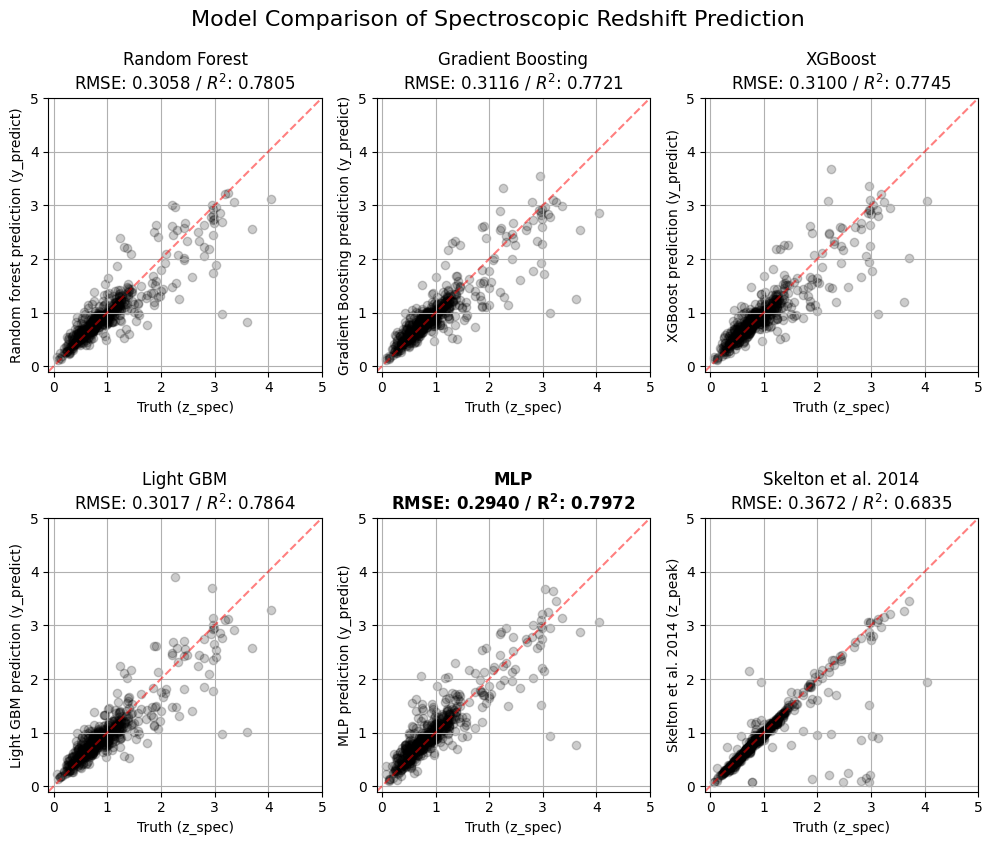

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(12, 10))

for i in range(2):
    for j in range(3):
        ax[i, j].plot([-0.1, 5], [-0.1, 5], color='red', linestyle='--', alpha=0.5)

ax[0, 0].scatter(y_validate, y_predict_validate_rf, alpha=0.2, color='black')
ax[0, 0].set_aspect('equal')
ax[0, 0].set_xlim(-0.1, 5)
ax[0, 0].set_ylim(-0.1, 5)
ax[0, 0].grid()
ax[0, 0].set_xlabel('Truth (z_spec)')
ax[0, 0].set_ylabel('Random forest prediction (y_predict)')
ax[0, 0].set_title(f'Random Forest\nRMSE: {np.sqrt(mse_rf):.4f} / $R^2$: {r2_rf:.4f}')

ax[0, 1].scatter(y_validate, y_predict_validate_gbr, alpha=0.2, color='black')
ax[0, 1].set_aspect('equal')
ax[0, 1].set_xlim(-0.1, 5)
ax[0, 1].set_ylim(-0.1, 5)
ax[0, 1].grid()
ax[0, 1].set_xlabel('Truth (z_spec)')
ax[0, 1].set_ylabel('Gradient Boosting prediction (y_predict)')
ax[0, 1].set_title(f'Gradient Boosting\nRMSE: {np.sqrt(mse_gbr):.4f} / $R^2$: {r2_gbr:.4f}')

ax[0, 2].scatter(y_validate, y_predict_validate_xgb, alpha=0.2, color='black')
ax[0, 2].set_aspect('equal')
ax[0, 2].set_xlim(-0.1, 5)
ax[0, 2].set_ylim(-0.1, 5)
ax[0, 2].grid()
ax[0, 2].set_xlabel('Truth (z_spec)')
ax[0, 2].set_ylabel('XGBoost prediction (y_predict)')
ax[0, 2].set_title(f'XGBoost\nRMSE: {np.sqrt(mse_xgb):.4f} / $R^2$: {r2_xgb:.4f}')

ax[1, 0].scatter(y_validate, y_predict_validate_lgbm, alpha=0.2, color='black')
ax[1, 0].set_aspect('equal')
ax[1, 0].set_xlim(-0.1, 5)
ax[1, 0].set_ylim(-0.1, 5)
ax[1, 0].grid()
ax[1, 0].set_xlabel('Truth (z_spec)')
ax[1, 0].set_ylabel('Light GBM prediction (y_predict)')
ax[1, 0].set_title(f'Light GBM\nRMSE: {np.sqrt(mse_lgbm):.4f} / $R^2$: {r2_lgbm:.4f}')

ax[1, 1].scatter(y_validate, y_predict_validate_mlp, alpha=0.2, color='black')
ax[1, 1].set_aspect('equal')
ax[1, 1].set_xlim(-0.1, 5)
ax[1, 1].set_ylim(-0.1, 5)
ax[1, 1].grid()
ax[1, 1].set_xlabel('Truth (z_spec)')
ax[1, 1].set_ylabel('MLP prediction (y_predict)')
ax[1, 1].set_title(f'MLP\nRMSE: {np.sqrt(mse_mlp):.4f} / $\mathbf{{R^2}}$: {r2_mlp:.4f}', fontweight='bold')

ax[1, 2].scatter(y_validate, y_skelton2014, alpha=0.2, color='black')
ax[1, 2].set_aspect('equal')
ax[1, 2].set_xlim(-0.1, 5)
ax[1, 2].set_ylim(-0.1, 5)
ax[1, 2].grid()
ax[1, 2].set_xlabel('Truth (z_spec)')
ax[1, 2].set_ylabel('Skelton et al. 2014 (z_peak)')
ax[1, 2].set_title(f'Skelton et al. 2014\nRMSE: {np.sqrt(mse_skelton):.4f} / $R^2$: {r2_skelton:.4f}')

fig.suptitle('Model Comparison of Spectroscopic Redshift Prediction', fontsize=16, y=0.93)

plt.show()

---